# _(Diesmann, et, al., 1999)_ Synfire Chains

Implementation of the paper:

- Diesmann, Markus, Marc-Oliver Gewaltig, and Ad Aertsen. "Stable propagation of synchronous spiking in cortical neural networks." Nature 402.6761 (1999): 529-533.

Author: [Chaoming Wang](mailto:chao.brain@qq.com)

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')

In [2]:
duration = 100.  # ms

# Neuron model parameters
Vr = -70.  # mV
Vt = -55.  # mV
tau_m = 10.  # ms
tau_ref = 1.  # ms
tau_psp = 0.325  # ms
weight = 4.86  # mV
noise = 39.24  # mV

# Neuron groups
n_groups = 10
group_size = 100
spike_sigma = 1.

# Synapse parameter
delay = 5.0  # ms

In [ ]:
# neuron model
# ------------


class Groups(bp.dyn.NeuGroup):
  def __init__(self, size, **kwargs):
    super(Groups, self).__init__(size, **kwargs)

    self.V = bm.Variable(Vr + bm.random.random(self.num) * (Vt - Vr))
    self.x = bm.Variable(bm.zeros(self.num))
    self.y = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.refractory = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)

    # integral functions
    self.int_V = bp.odeint(lambda V, t, x: (-(V - Vr) + x) / tau_m)
    self.int_x = bp.odeint(lambda x, t, y: (-x + y) / tau_psp)
    self.int_y = bp.sdeint(f=lambda y, t: -y / tau_psp + 25.27, g=lambda y, t: noise)

  def update(self, _t, _dt):
    self.x[:] = self.int_x(self.x, _t, self.y, _dt)
    self.y[:] = self.int_y(self.y, _t, _dt)
    in_ref = (_t - self.t_last_spike) < tau_ref
    V = self.int_V(self.V, _t, self.x, _dt)
    V = bm.where(in_ref, self.V, V)
    self.spike.value = V >= Vt
    self.t_last_spike.value = bm.where(self.spike, _t, self.t_last_spike)
    self.V.value = bm.where(self.spike, Vr, V)
    self.refractory.value = bm.logical_or(in_ref, self.spike)

In [ ]:
# synaptic  model
# ---------------

class SynBetweenGroups(bp.dyn.TwoEndConn):
  def __init__(self, group, ext_group, **kwargs):
    super(SynBetweenGroups, self).__init__(group, group, **kwargs)

    self.group = group
    self.ext = ext_group

    # variables
    self.delay_step = int(delay/bm.get_dt())
    self.g = bm.LengthDelay(bm.zeros(self.group.num), self.delay_step)

  def update(self, _t, _dt):
    # synapse model between external and group 1
    g = bm.zeros(self.group.num)
    g[:group_size] = weight * self.ext.spike.sum()
    # feed-forward connection
    for i in range(1, n_groups):
      s1 = (i - 1) * group_size
      s2 = i * group_size
      s3 = (i + 1) * group_size
      g[s2: s3] = weight * self.group.spike[s1: s2].sum()
    # delay push
    self.g.update(g)
    # delay pull
    self.group.y += self.g(self.delay_step)

In [ ]:
# network running
# ---------------

def run_network(spike_num=48):
  bm.random.seed(12345)
  times = bm.random.randn(spike_num) * spike_sigma + 20
  ext_group = bp.dyn.SpikeTimeInput(spike_num, times=times.value, indices=bm.arange(spike_num).value)
  group = Groups(size=n_groups * group_size)
  syn_conn = SynBetweenGroups(group, ext_group)
  net = bp.dyn.Network(ext_group=ext_group, syn_conn=syn_conn, group=group)

  # simulation
  runner = bp.dyn.DSRunner(net,
                           monitors=['group.spike'],
                           dyn_vars=net.vars() + dict(rng=bm.random.DEFAULT))
  runner.run(duration)

  # visualization
  bp.visualize.raster_plot(runner.mon.ts, runner.mon['group.spike'],
                           xlim=(0, duration), show=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

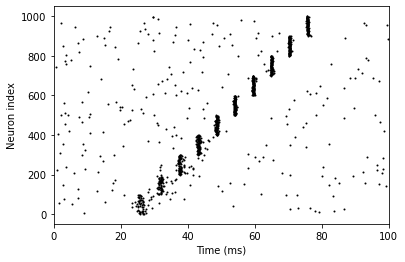

In [7]:
run_network(spike_num=51)

When external spike num is 44, the synchronous excitation disperses and eventually dies out.

  0%|          | 0/1000 [00:00<?, ?it/s]

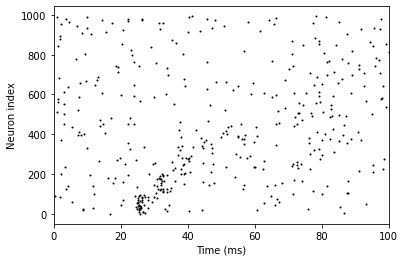

In [8]:
run_network(spike_num=44)